# Field Star Extrapolation

This notebook looks at the magnitude-limited observed stars, and simulates a background star population on a row-wise basis in 'l' and 'b' space. 

Here's how it works:
1. Import magnitude-limited observed data
2. Mask out stars near the cluster center
3. Bin stars by rows in 'b' and calculate star count, area, and then density per row
4. For each row, make copies of real stars that are also in that row, # to match the density. Keep their proper motions, but assign random positions within that row.
5. Take a look at the new stars and export

In [1]:
# General imports
import pandas as pd
import numpy as np

# To convert coordinates to Galactic l and b (for simulating field stars)
from astropy.coordinates import SkyCoord
import astropy.units as u

# Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.patches import Circle

# Math stuff
import math
from scipy.stats import norm
import shapely.geometry as geom
import shapely.ops as ops
from shapely import affinity

# 1. Import stars

In [3]:
observed_df_cut = pd.read_csv('C:/Users/smick/Desktop/Research/notebooks/piecewise/observed_stars_mag_limited.csv')

# 2. Mask out central stars

Define the cluster center according to published literature, and establish a bounding box that contains stars we want to exclude from our field star density calculation. Create new arrays for the stars that are located outside of this box.

In [4]:
# Cluster center of cluster in (hours, minutes, seconds) (NGC 6569 data from Ortelani, et al., 2001)
ra_center_hms = (18, 13, 38.9)  
dec_center_dms = (-31, 49, 35)  

# Convert to decimal degrees
ra_center = 15 * (ra_center_hms[0] + ra_center_hms[1] / 60 + ra_center_hms[2] / 3600)
dec_center = dec_center_dms[0] - dec_center_dms[1] / 60 - dec_center_dms[2] / 3600

# Create SkyCoord object for cluster center
cluster_coords = SkyCoord(ra=ra_center,
                  dec=dec_center,
                  unit=(u.degree,u.degree),
                  frame='icrs') 

# Convert cluster center to Galactic l and b
center_l = cluster_coords.galactic.l.wrap_at(180 * u.degree).deg  
center_b = cluster_coords.galactic.b.deg  
print(center_l,center_b)

0.4815219768413071 -6.68098773641404


In [5]:
# Define the bounding box for the cluster center
square_half_width = 0.05 #0.01^2 = 0.0001 sqdeg to exclude

# Set mins and maxes for bounding box edges
cluster_l_min = center_l - square_half_width
cluster_l_max = center_l + square_half_width
cluster_b_min = center_b - square_half_width
cluster_b_max = center_b + square_half_width

# Create a mask for stars outside of the cluster bounding box
outside_cluster_mask = ~(
    (observed_df_cut['l'] >= cluster_l_min) & (observed_df_cut['l'] <= cluster_l_max) &
    (observed_df_cut['b'] >= cluster_b_min) & (observed_df_cut['b'] <= cluster_b_max)
)

# Create new array for the l and b coordinates of these stars outside of the bounding box
observed_l_outside = observed_df_cut['l'][outside_cluster_mask]
observed_b_outside = observed_df_cut['b'][outside_cluster_mask]

# 3. Bin stars by row

Using the minima and maxima of the observed data, create the number of rows needed to meet the desired resolution.

In [6]:
# Set mins and maxes in l and b
b_min, b_max = np.min(observed_df_cut['b']), np.max(observed_df_cut['b'])
l_min, l_max = np.min(observed_df_cut['l']), np.max(observed_df_cut['l'])

# Calculate radius
R = ((center_l - l_min) + (l_max - center_l) + (center_b - b_min) + (b_max - center_b)) / 4
print(R)

# Define number of rows to bin by
N_rows = 100 #1/100 = 0.001 degrees per bin

# Define bin edges 
b_edges = np.linspace(b_min, b_max, N_rows +1) 

# Define midpoints 
b_mids = 0.5 * (b_edges[:-1] + b_edges[1:])

# Initialize arrays for counts and areas
row_counts = np.zeros(N_rows)
row_areas = np.zeros(N_rows)

0.5011003509440345


Because we are working with rectangular rows in a circular field of view, we need to account for the overlap at the edges of each row, where it exceeds the FOV and no stars are found. At the same time, we need to exclude the area of the bounding box from the calculations.

In [7]:
# Create a shape the dimensions of the observed data's field of view
center = geom.Point(center_l, center_b)
circle_polygon = center.buffer(R, resolution=256)  

# Create a shape for the cluster bounding box
cluster_box_polygon = geom.Polygon([
    (cluster_l_min, cluster_b_min),
    (cluster_l_min, cluster_b_max),
    (cluster_l_max, cluster_b_max),
    (cluster_l_max, cluster_b_min),
])

# Define row limits in 'l':
full_lmin = l_min
full_lmax = l_max

# Loop through each row and count stars
for i in range(N_rows):
    b_lower = b_edges[i] # pull 'b' boundaries
    b_upper = b_edges[i + 1]
    
    # Define the four points of each row rectangle
    row_rect = geom.Polygon([
        (full_lmin, b_lower),
        (full_lmin, b_upper),
        (full_lmax, b_upper),
        (full_lmax, b_lower),
    ])
    
    # Find the intersection of row and circle:
    row_in_circle = row_rect.intersection(circle_polygon)

    # Calculate area of that intersection
    row_area_in_circle = row_in_circle.area

    # Repeat to calculate portion of this row inside the circle AND inside cluster bounding box. This is the area around cluster center that we don't want to count.
    row_in_circle_and_box = row_in_circle.intersection(cluster_box_polygon)
    box_overlap_area = row_in_circle_and_box.area
    
    # Subtract away the cluster bounding box area 
    row_area_outside_box = row_area_in_circle - box_overlap_area
    row_areas[i] = row_area_outside_box # this is the area of the row that we will use for density calculation

    # Define a mask for stars within this row
    in_row = (
        (observed_b_outside >= b_lower) & (observed_b_outside < b_upper) &
        ((observed_l_outside - center_l)**2 + (observed_b_outside - center_b)**2 <= R**2)
    )
    # Count
    row_counts[i] = np.sum(in_row)

# Use counts and areas to calculate density per row
density_per_row = row_counts / row_areas

Now that we have densities per row, we need to go back through each row and generate new stars at random locations. 

In [8]:
# Define a function to randomly sample a number of points within the area of a polygon 
def sample_points_in_polygon(polygon, n_points):
    rng = np.random.default_rng()
    minx, miny, maxx, maxy = polygon.bounds
    
    points = []
    # Keep generating until we have n_points inside 'polygon'
    while len(points) < n_points:
        # Generate random x and y coords within in bounding box
        x = rng.uniform(minx, maxx)
        y = rng.uniform(miny, maxy)
        p = geom.Point(x, y) # define point as pair of x and y coords
        if polygon.contains(p): 
            points.append([x, y]) # add point if it falls within area of row
            
    return np.array(points)

Now we can create a loop that makes a number of copies of real field stars from within that row, then assigns randomly generated coordinates within that row's 'l' and 'b' limits, but retains the proper motions and parallax values. This is then combined to create our simulated field dataframe.  

In [9]:
# Initialize array
simulated_row_list = []

for i in range(N_rows):

    # Define row boundaries in b
    b_lower = b_edges[i]
    b_upper = b_edges[i + 1]
    
    # Create the row rectangle
    row_rect = geom.Polygon([
        (l_min, b_lower),
        (l_min, b_upper),
        (l_max, b_upper),
        (l_max, b_lower),
    ])

    # Intersect with the circle polygon and calculate area
    row_in_circle = row_rect.intersection(circle_polygon)
    row_area_total = row_in_circle.area
    
    # Retrieve the row's star density
    row_density = density_per_row[i] 
    
    # Set number of stars needed to populate row
    n_new = int(round(row_density * row_area_total))

    # Identify the stars outside the cluster bounding box in this row
    in_row_field_mask = (
        (observed_df_cut['b'] >= b_lower) & (observed_df_cut['b'] < b_upper)
        & ((observed_df_cut['l'] - center_l)**2 + (observed_df_cut['b'] - center_b)**2 <= R**2)
        & outside_cluster_mask
    )
    row_field_stars = observed_df_cut[in_row_field_mask]
    
    # Sample star properties from row_field_stars with replacement
    rng = np.random.default_rng()
    chosen_indices = rng.integers(0, len(row_field_stars), size=n_new) # generate a list of random indices to be pulled
    new_star_props = row_field_stars.iloc[chosen_indices].copy() # create copies of the random stars
    
    # Generate n_new random positions throughout the entire row, including the cluster bounding box
    new_lb = sample_points_in_polygon(row_in_circle, n_new)
    
    # Overwrite l and b of the new stars
    new_star_props.loc[:, 'l'] = new_lb[:, 0]
    new_star_props.loc[:, 'b'] = new_lb[:, 1]
    
    # Collect this row's new stars
    simulated_row_list.append(new_star_props)

# Concatenate all the rows
simulated_df = pd.concat(simulated_row_list, ignore_index=True)
print("Created a simulated dataset with", len(simulated_df), "stars.")

# Calculate ra and dec for the new stars
coords = SkyCoord(l=simulated_df['l'].values * u.degree,
                 b=simulated_df['b'].values * u.degree,
                 frame='galactic')

icrs = coords.icrs  # Transform to ICRS frame
simulated_df['radeg'] = icrs.ra.degree
simulated_df['decdeg'] = icrs.dec.degree

Created a simulated dataset with 313009 stars.


# 5. Export

Take a quick look at how the new stars look against the observed dataset to make sure things are looking as we'd expect.

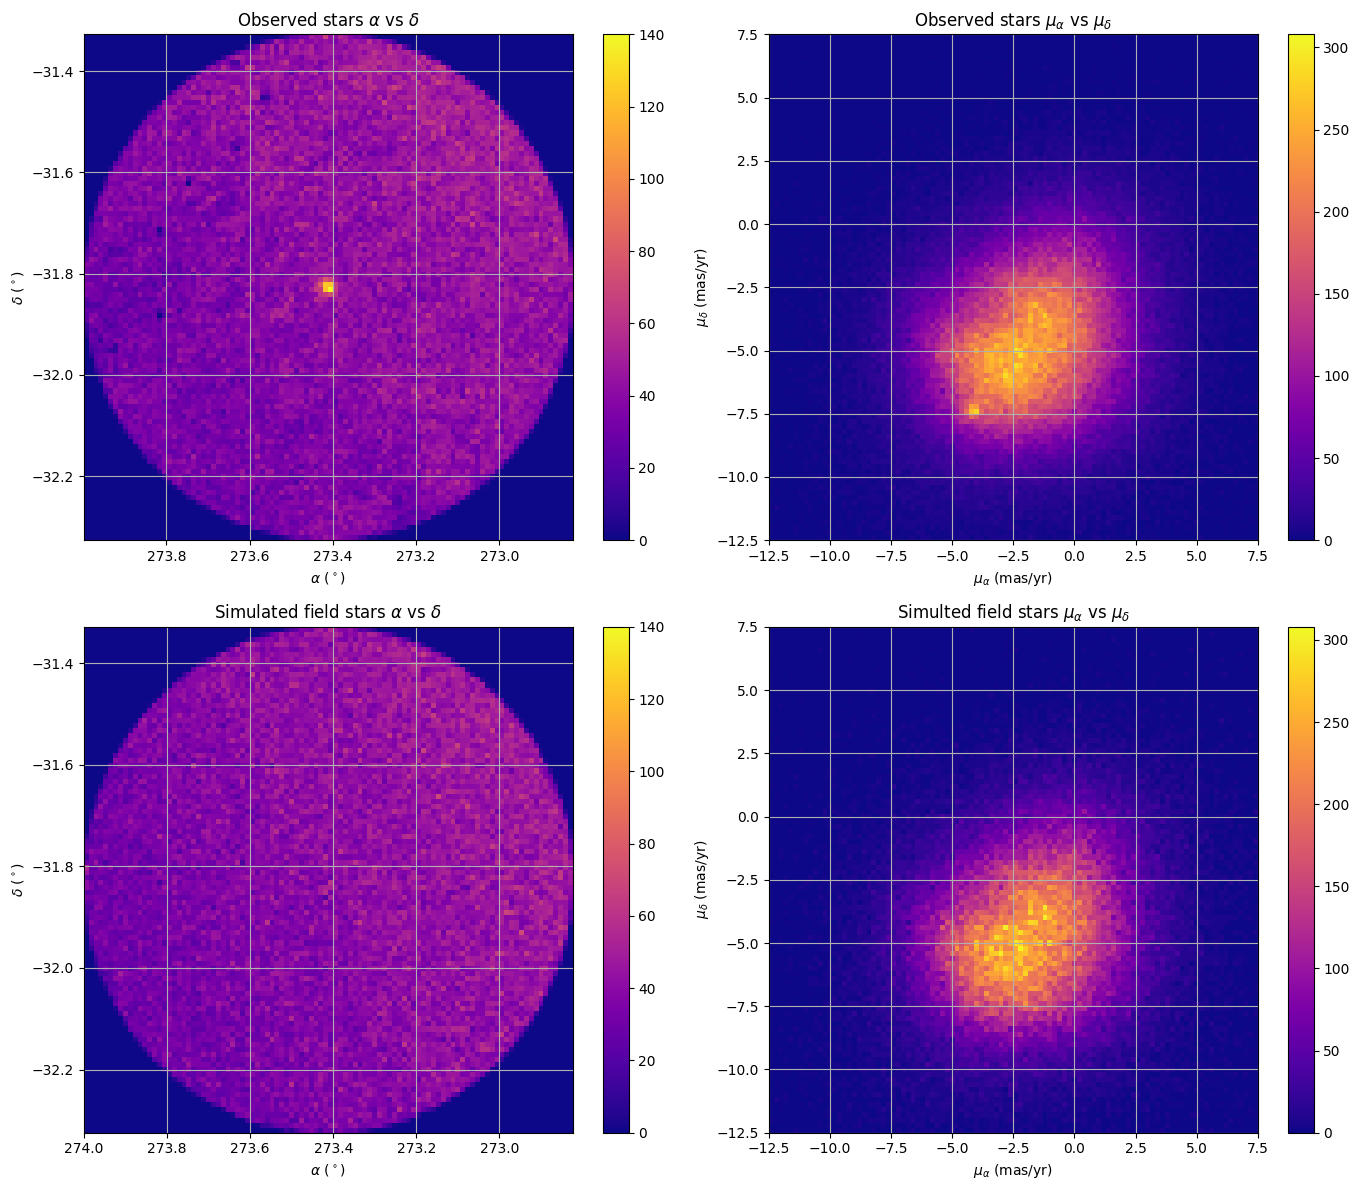

In [10]:
# Initialize arrays for the histogram densities. We'll use this to create a uniform colorbar for better comparison between the two datasets.
pos_densities = []
pm_densities = []

# Compute 2D histogram densities for each plot
h1_data, _, _ = np.histogram2d(observed_df_cut['radeg'], observed_df_cut['decdeg'], bins=100)
h2_data, _, _ = np.histogram2d(observed_df_cut['pmra'], observed_df_cut['pmdec'], bins=100, range=[[-12.5,7.5], [-12.5,7.5]])
h3_data, _, _ = np.histogram2d(simulated_df['radeg'], simulated_df['decdeg'], bins=100)
h4_data, _, _ = np.histogram2d(simulated_df['pmra'], simulated_df['pmdec'], bins=100, range=[[-12.5,7.5], [-12.5,7.5]])

# Collect the position and proper motion histogram counts 
pos_densities = np.concatenate([h1_data.flatten(), h3_data.flatten()])                             
pm_densities = np.concatenate([h2_data.flatten(), h4_data.flatten()])

# Get the minimum and maximum values for the color bar
pos_vmin = pos_densities.min()
pos_vmax = pos_densities.max()

pm_vmin = pm_densities.min()
pm_vmax = pm_densities.max()

# Start plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 12)) 
axes = axes.ravel()

# RA v DEC for Field + Cluster
h1 = axes[0].hist2d(
    observed_df_cut['radeg'],
    observed_df_cut['decdeg'],
    bins=100, # set this to the number of rows generated, or increase it for a finer visualization
    cmap='plasma',
    vmin=pos_vmin, # set limits of colorbar to the full min and max
    vmax=pos_vmax
)
axes[0].set_xlabel(r'$\alpha$ $(^\circ)$')
axes[0].invert_xaxis()
axes[0].set_ylabel(r'$\delta$ $(^\circ)$')
axes[0].grid(True)
axes[0].set_title(r'Observed stars $\alpha$ vs $\delta$')
fig.colorbar(h1[3], ax=axes[0])

# PMRA vs PMDEC for Field + Cluster 
h2 = axes[1].hist2d(
    observed_df_cut['pmra'], 
    observed_df_cut['pmdec'], 
    bins=100, 
    range=[[-12.5,7.5], [-12.5,7.5]], 
    cmap='plasma',
    vmin=pm_vmin,
    vmax=pm_vmax
)
axes[1].set_xlabel(r'$\mu_{\alpha}$ (mas/yr)')
axes[1].set_ylabel(r'$\mu_{\delta}$ (mas/yr)')
axes[1].grid(True)
axes[1].set_title(r'Observed stars $\mu_{\alpha}$ vs $\mu_{\delta}$')
fig.colorbar(h2[3], ax=axes[1])

# RA vs DEC for field-only 
h3 = axes[2].hist2d(
    simulated_df['radeg'], 
    simulated_df['decdeg'], 
    bins=100, 
    cmap='plasma', 
    vmin=pos_vmin, 
    vmax=pos_vmax
)
axes[2].set_xlabel(r'$\alpha$ $(^\circ)$')
axes[2].set_ylabel(r'$\delta$ $(^\circ)$')
axes[2].invert_xaxis()
axes[2].grid(True)
axes[2].set_title(r'Simulated field stars $\alpha$ vs $\delta$')
fig.colorbar(h3[3], ax=axes[2])

# PMRA vs PMDEC for field-only
h4 = axes[3].hist2d(
    simulated_df['pmra'], 
    simulated_df['pmdec'], 
    bins=100, 
    range=[[-12.5,7.5], [-12.5,7.5]], 
    cmap='plasma',
    vmin=pm_vmin,
    vmax=pm_vmax
)
axes[3].set_xlabel(r'$\mu_{\alpha}$ (mas/yr)')
axes[3].set_ylabel(r'$\mu_{\delta}$ (mas/yr)')
axes[3].grid(True)
axes[3].set_title(r'Simulted field stars $\mu_{\alpha}$ vs $\mu_{\delta}$')
fig.colorbar(h4[3], ax=axes[3])


plt.tight_layout()
plt.show()

Export if everything looks good

In [11]:
simulated_df.to_csv('simulated_stars.csv', index=False)